# Pytorch

In [1]:
cd /content/drive/My Drive/Tobigs

/content/drive/My Drive/Tobigs


In [2]:
ls

CNN_keras_sub.csv     sample_submission.csv  torch_submission.csv
kaggle.json           test_df.csv            train_df.csv
radam_submission.csv  test_df.csv.zip        train_df.csv.zip


## Import Library

In [0]:
# data
import pandas as pd
import numpy as np

# model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Preprocessing

In [0]:
sample_submission = pd.read_csv("sample_submission.csv")
train = pd.read_csv("train_df.csv")
test = pd.read_csv("test_df.csv")

In [6]:
## Normalization
X = train.drop('label', axis=1).values

train_mean = X.mean() / 255.0
train_std = X.std() / 255.0

print('Mean: ', train_mean)
print('Std: ', train_std)

Mean:  0.08216706587396863
Std:  0.2416065068266839


In [7]:
# Train-Val split
mask = np.random.rand(len(train)) < 0.9
df_val = train[~mask]
df_train = train[mask]

print('Train size: ', df_train.shape)
print('Val size: ', df_val.shape)
print('Test size: ', test.shape)

Train size:  (37724, 785)
Val size:  (4276, 785)
Test size:  (18000, 785)


## Load Data

In [0]:
class MNISTDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, n):
        data = self.df.iloc[n]
        image = data[1:].values.reshape((28,28)).astype(np.uint8)
        label = data[0]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [0]:
## Define Data Loaders and Data Augmentation
batch_size = 16
classes = range(10)

train_transform = transforms.Compose(
                    [
                    transforms.ToPILImage(), # PILImage로 변환
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)), # Data Augmentation
                    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Data Augmentation
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]), # Normalize
                    ])

In [0]:
val_transform = transforms.Compose(
                    [
                    transforms.ToPILImage(), # PILImage로 변환
                    transforms.ToTensor(),
                    # validation data의 경우 data augmentation X
                    transforms.Normalize(mean=[train_mean], std=[train_std]), # Normalize
                    ])

test_transform = val_transform

In [0]:
# Loader 이용
train_dataset = MNISTDataset(df_train, transform = train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size, shuffle = True)

val_dataset = MNISTDataset(df_val, transform = val_transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                batch_size=batch_size, shuffle = False)

## Modeling

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10)
        )
                
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

model = Model()

### - Over9000 Optimizer

In [0]:
## Over9000 Optimizer . Inspired by Iafoss . Over and Out !
##https://github.com/mgrankin/over9000/blob/master/ralamb.py
import torch, math
from torch.optim.optimizer import Optimizer

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# Lookahead implementation from https://github.com/rwightman/pytorch-image-models/blob/master/timm/optim/lookahead.py

""" Lookahead Optimizer Wrapper.
Implementation modified from: https://github.com/alphadl/lookahead.pytorch
Paper: `Lookahead Optimizer: k steps forward, 1 step back` - https://arxiv.org/abs/1907.08610
"""
import torch
from torch.optim.optimizer import Optimizer
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print('Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups': state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)

def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
     adam = Adam(params, *args, **kwargs)
     return Lookahead(adam, alpha, k)


# RAdam + LARS + LookAHead

# Lookahead implementation from https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
# RAdam + LARS implementation from https://gist.github.com/redknightlois/c4023d393eb8f92bb44b2ab582d7ec20

def Over9000(params, alpha=0.5, k=6, *args, **kwargs):
     ralamb = Ralamb(params, *args, **kwargs)
     return Lookahead(ralamb, alpha, k)

RangerLars = Over9000 

In [0]:
import torch.optim as optim

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Over9000(model.parameters(), lr=2e-3, weight_decay=1e-3)

In [15]:
model

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5):

## Training

In [16]:
import time
import copy

# Hyperparameter
epochs = 50
train_losses, val_losses = [], []
train_accu, val_accu = [], []
start_time = time.time()
early_stop_counter = 10   # stop when the validation loss does not improve for 10 iterations to prevent overfitting
counter = 0
best_val_loss = float('Inf')

for e in range(epochs):
    epoch_start_time = time.time()
    running_loss = 0
    accuracy=0

    # training step
    model.train()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        
        ps = torch.exp(log_ps)                
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_accu.append(accuracy/len(train_loader))
    val_loss = 0
    accuracy=0
    model.eval()

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            log_ps = model(images)
            val_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    val_losses.append(val_loss/len(val_loader))
    val_accu.append(accuracy/len(val_loader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Time: {:.2f}s..".format(time.time()-epoch_start_time),
          "Training Loss: {:.4f}.. ".format(train_losses[-1]),
          "Training Accu: {:.4f}.. ".format(train_accu[-1]),
          "Val Loss: {:.4f}.. ".format(val_losses[-1]),
          "Val Accu: {:.4f}".format(val_accu[-1]))
 
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter=0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        counter+=1
        print('Validation loss has not improved since: {:.4f}..'.format(best_val_loss), 'Count: ', str(counter))
        if counter >= early_stop_counter:
            print('Early Stopping Now!!!!')
            model.load_state_dict(best_model_wts)
            break 

Epoch: 1/50..  Time: 68.24s.. Training Loss: 0.4726..  Training Accu: 0.8439..  Val Loss: 0.0321..  Val Accu: 0.9890
Epoch: 2/50..  Time: 67.65s.. Training Loss: 0.1196..  Training Accu: 0.9634..  Val Loss: 0.0267..  Val Accu: 0.9909
Epoch: 3/50..  Time: 67.24s.. Training Loss: 0.0903..  Training Accu: 0.9727..  Val Loss: 0.0205..  Val Accu: 0.9935
Epoch: 4/50..  Time: 67.21s.. Training Loss: 0.0765..  Training Accu: 0.9774..  Val Loss: 0.0172..  Val Accu: 0.9942
Epoch: 5/50..  Time: 66.90s.. Training Loss: 0.0642..  Training Accu: 0.9812..  Val Loss: 0.0201..  Val Accu: 0.9937
Validation loss has not improved since: 0.0172.. Count:  1
Epoch: 6/50..  Time: 66.62s.. Training Loss: 0.0547..  Training Accu: 0.9833..  Val Loss: 0.0166..  Val Accu: 0.9949
Epoch: 7/50..  Time: 66.17s.. Training Loss: 0.0504..  Training Accu: 0.9849..  Val Loss: 0.0195..  Val Accu: 0.9937
Validation loss has not improved since: 0.0166.. Count:  1
Epoch: 8/50..  Time: 66.29s.. Training Loss: 0.0471..  Training

## Evaluation

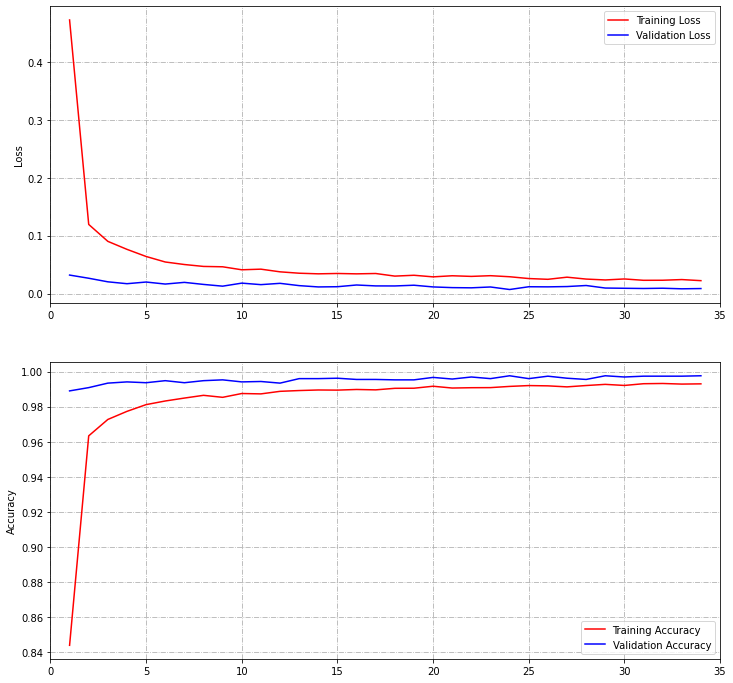

In [17]:
# plot training history
plt.figure(figsize=(12,12)) 
plt.subplot(2,1,1) 
ax = plt.gca()
ax.set_xlim([0, e + 2])
plt.ylabel('Loss')
plt.plot(range(1, e + 2), train_losses[:e+1], 'r', label='Training Loss')
plt.plot(range(1, e + 2), val_losses[:e+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.') 
plt.legend() 
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, e+2]) 
plt.ylabel('Accuracy')
plt.plot(range(1, e + 2), train_accu[:e+1], 'r', label='Training Accuracy')
plt.plot(range(1, e + 2), val_accu[:e+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

## Submission

In [0]:
test = test.iloc[:,1:]

In [0]:
x_test = test.values
x_test = x_test.reshape([-1, 28, 28]).astype(np.float)
x_test = x_test/255.0
x_test = (x_test-train_mean)/train_std

In [30]:
x_test = np.expand_dims(x_test, axis=1)
x_test = torch.from_numpy(x_test).float().to(device)
# x_test.shape
x_test.type()

'torch.cuda.FloatTensor'

In [31]:
model.eval()   # this is needed to disable dropouts
with torch.no_grad():    # turn off gradient computation because we don't need it for prediction
    ps = model(x_test)
    prediction = torch.argmax(ps, 1)
    print('Prediction', prediction)

Prediction tensor([8, 0, 5,  ..., 3, 4, 1], device='cuda:0')


In [32]:
sample_submission["Category"] = pd.Series(prediction.cpu().tolist())
sample_submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [0]:
sample_submission.to_csv("CNN_pytorch_sub.csv", index=False)

## Reference Kernel

https://www.kaggle.com/enwei26/mnist-digits-pytorch-cnn-99